<h1>CNN + Simple RNN</h1>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

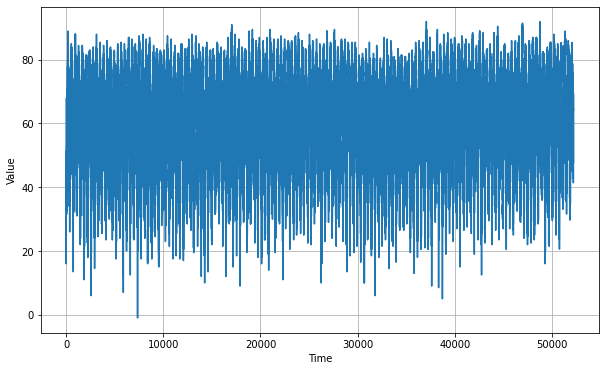

In [3]:
import csv
time_step = []
temps = []

with open('Birmingham-mean.csv') as csvfile:    
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 40000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.SimpleRNN(100, return_sequences=True, activation='relu'),     
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(40000,)
Epoch 1/100
156/156 [==============================] - 14s 71ms/step - loss: 227.6047 - mae: 8.5479
Epoch 2/100
156/156 [==============================] - 11s 66ms/step - loss: 25.2122 - mae: 3.7405
Epoch 3/100
156/156 [==============================] - 11s 67ms/step - loss: 24.3494 - mae: 3.6895
Epoch 4/100
156/156 [==============================] - 11s 72ms/step - loss: 24.0255 - mae: 3.6630
Epoch 5/100
156/156 [==============================] - 12s 75ms/step - loss: 23.9389 - mae: 3.6538
Epoch 6/100
156/156 [==============================] - 12s 76ms/step - loss: 23.9423 - mae: 3.6557
Epoch 7/100
156/156 [==============================] - 11s 73ms/step - loss: 23.8208 - mae: 3.6456
Epoch 8/100
156/156 [==============================] - 12s 77ms/step - loss: 23.8093 - mae: 3.6470
Epoch 9/100
156/156 [==============================] - 12s 74ms/step - loss: 23.7242 - mae: 3.6390
Epoch

Epoch 82/100
156/156 [==============================] - 12s 75ms/step - loss: 21.0114 - mae: 3.4357
Epoch 83/100
156/156 [==============================] - 12s 74ms/step - loss: 20.9412 - mae: 3.4335
Epoch 84/100
156/156 [==============================] - 12s 73ms/step - loss: 20.8511 - mae: 3.4263
Epoch 85/100
156/156 [==============================] - 11s 73ms/step - loss: 20.7322 - mae: 3.4179
Epoch 86/100
156/156 [==============================] - 12s 75ms/step - loss: 20.7412 - mae: 3.4189
Epoch 87/100
156/156 [==============================] - 11s 72ms/step - loss: 20.7046 - mae: 3.4172
Epoch 88/100
156/156 [==============================] - 11s 73ms/step - loss: 20.6966 - mae: 3.4178
Epoch 89/100
156/156 [==============================] - 12s 76ms/step - loss: 20.5606 - mae: 3.4035
Epoch 90/100
156/156 [==============================] - 12s 74ms/step - loss: 20.4771 - mae: 3.3979
Epoch 91/100
156/156 [==============================] - 12s 76ms/step - loss: 20.3140 - mae: 3.3836


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         13300     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3030      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
Total params: 36,943
Trainable params: 36,943
Non-trainable params: 0
____________________________________________________

In [9]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

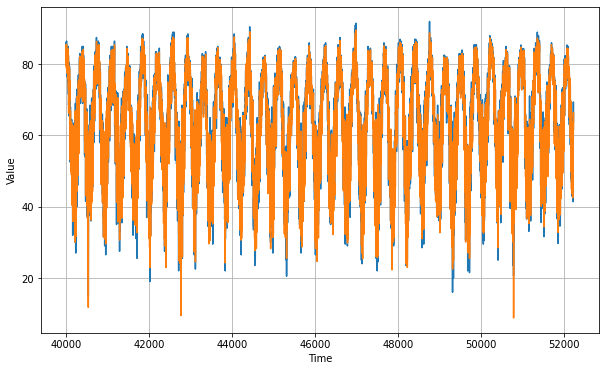

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

3.5161986

In [12]:
model.save('CNN_RNN_model.h5')

In [13]:
model = tf.keras.models.load_model('CNN_RNN_model.h5')